### Configuração do Ambiente e Carregamento dos Dados



A primeira etapa do processo consiste na configuração do ambiente de execução e no carregamento dos dados brutos de acidentes de trânsito. Inicialmente, o diretório `/home/jovyan/work` é adicionado ao caminho de busca do Python (`sys.path`), o que permite a importação adequada de módulos personalizados desenvolvidos para o projeto.

Em seguida, são importadas as classes auxiliares `DataLoader` e `Workload`, localizadas no pacote `utils`. A classe `DataLoader` é responsável por localizar, ler e consolidar os arquivos CSV contendo os registros históricos de acidentes, enquanto a classe `Workload` representa uma abstração de tarefas analíticas que serão aplicadas ao conjunto de dados.

Com o carregador de dados instanciado, utilizando como diretório base `/home/jovyan/work/full_data`, o método `load()` é chamado para efetuar a leitura de todos os arquivos CSV presentes nesse caminho. O resultado é um único `DataFrame` do PySpark, que unifica os dados de diferentes anos e será utilizado nas análises subsequentes. Essa abordagem facilita a organização e a reutilização das rotinas de análise ao longo do projeto.


In [1]:
import sys
sys.path.append("/home/jovyan/work")

from utils.dataloader import DataLoader
from utils.workload import Workload

# Carrega todos os arquivos CSV
loader = DataLoader(base_dir="/home/jovyan/work/full_data")
df = loader.load()

### Análise Temporal de Acidentes: Distribuição por Hora do Dia

A análise de distribuição de acidentes por hora do dia tem como objetivo identificar a frequência com que os acidentes de trânsito ocorrem ao longo das 24 horas do dia. Esta análise é realizada com base no campo `horario` presente na base de dados consolidada de acidentes, que inclui registros de diversos anos.

Para isso, foi definida uma carga de trabalho (`Workload`) que utiliza PySpark para realizar a transformação dos dados, extraindo a hora de cada ocorrência e agrupando os registros por esse valor. O número de acidentes por hora é então contado e ordenado para facilitar a interpretação.

Após a etapa de processamento, os resultados são convertidos para um DataFrame pandas, permitindo a geração de um gráfico de barras com a biblioteca Matplotlib. Esse gráfico ilustra visualmente como os acidentes se distribuem ao longo do dia, possibilitando a identificação de faixas horárias com maior ou menor incidência de ocorrências.

[WORKLOAD-1] Visualiza a frequência de acidentes ao longo das 24 horas do dia, com base nos registros de todos os anos. (Distribuição de Acidentes por Hora do Dia)


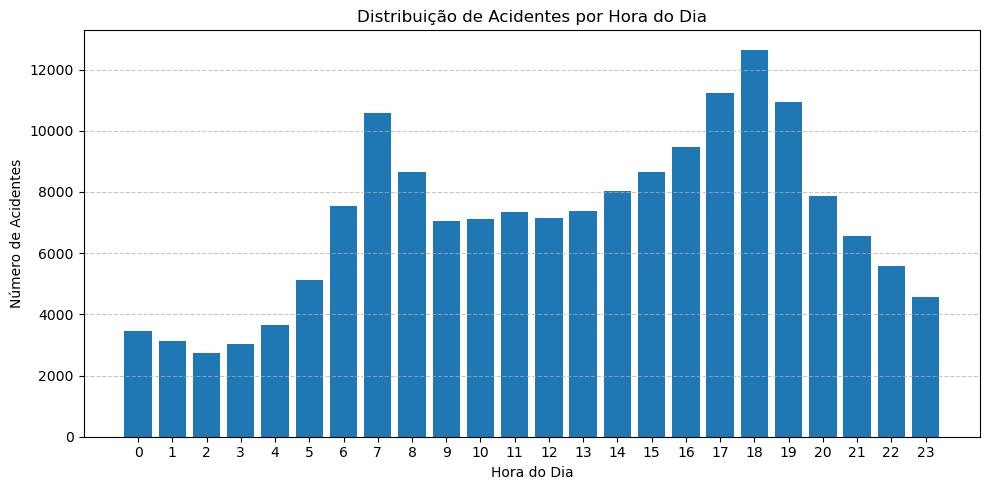

[INFO] Tempo de execução da workload 'Distribuição de Acidentes por Hora do Dia': 2.63 segundos


In [2]:
# Define uma workload de análise por hora
def analise_por_hora(df):
    from pyspark.sql.functions import hour, col
    import matplotlib.pyplot as plt

    # Extrai a hora do campo 'horario'
    df_com_hora = df.withColumn("hora", hour(col("horario")))

    # Agrupa e conta acidentes por hora
    agrupado = df_com_hora.groupBy("hora").count().orderBy("hora")

    # Coleta para o driver para plotar
    resultados = agrupado.toPandas()

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(resultados['hora'], resultados['count'], width=0.8)
    plt.xlabel("Hora do Dia")
    plt.ylabel("Número de Acidentes")
    plt.title("Distribuição de Acidentes por Hora do Dia")
    plt.xticks(range(0, 24))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
 
workload = Workload(
    name="Distribuição de Acidentes por Hora do Dia",
    description="[WORKLOAD-1] Visualiza a frequência de acidentes ao longo das 24 horas do dia, com base nos registros de todos os anos.",
    execute_fn=analise_por_hora
)

# Executa a workload
workload.run(df)